# Pseudobulk ATAC

## Inputs

In [1]:
source('jupyterFunctions_perCellType.R')

In [2]:
data_prefix <- paste(sep='','../data/')
Tcell_pval <- readRDS(paste(sep='',data_prefix,'Tcell/Tcell_pseudobulkATAC_diffState_pvalDF.rds'))
stromal_pval <- readRDS(paste(sep='',data_prefix,'stromal/stromal_pseudobulkATAC_diffState_pvalDF.rds'))
myeloid_pval <- readRDS(paste(sep='',data_prefix,'myeloid/myeloid_pseudobulkATAC_diffState_pvalDF.rds'))

TA1_stats <- readRDS(paste(sep='',data_prefix,'Tcell/Tcell_pseudobulkATAC_TA1_diffState_statsDF.rds'))
Tcell_class_state_df <- readRDS(paste(sep='',data_prefix,'Tcell/Tcell_class_state_df.rds'))
Tcell_meta <- readRDS(paste(sep='',data_prefix,'Tcell/Tcell_ATAC_meta.rds'))

In [3]:
ATAC_colors <- readRDS('../data/misc/ATAC_class_colors.rds')
broadCT_colors <- readRDS('../data/misc/broadCT_colors.rds')
CITE_colors <- readRDS('../data/misc/CITE_state_colors.rds')

In [12]:
save_dir <- NA #'../output_v9/' #or NA if don't want to save
file_extension <- '.pdf'

## Global figure

In [5]:
using_colors <- c(ATAC_colors,'allT'=unname(broadCT_colors['Tcell']),'allStromal'=unname(broadCT_colors['stromal']),
                  'allMyeloid'=unname(broadCT_colors['myeloid']))

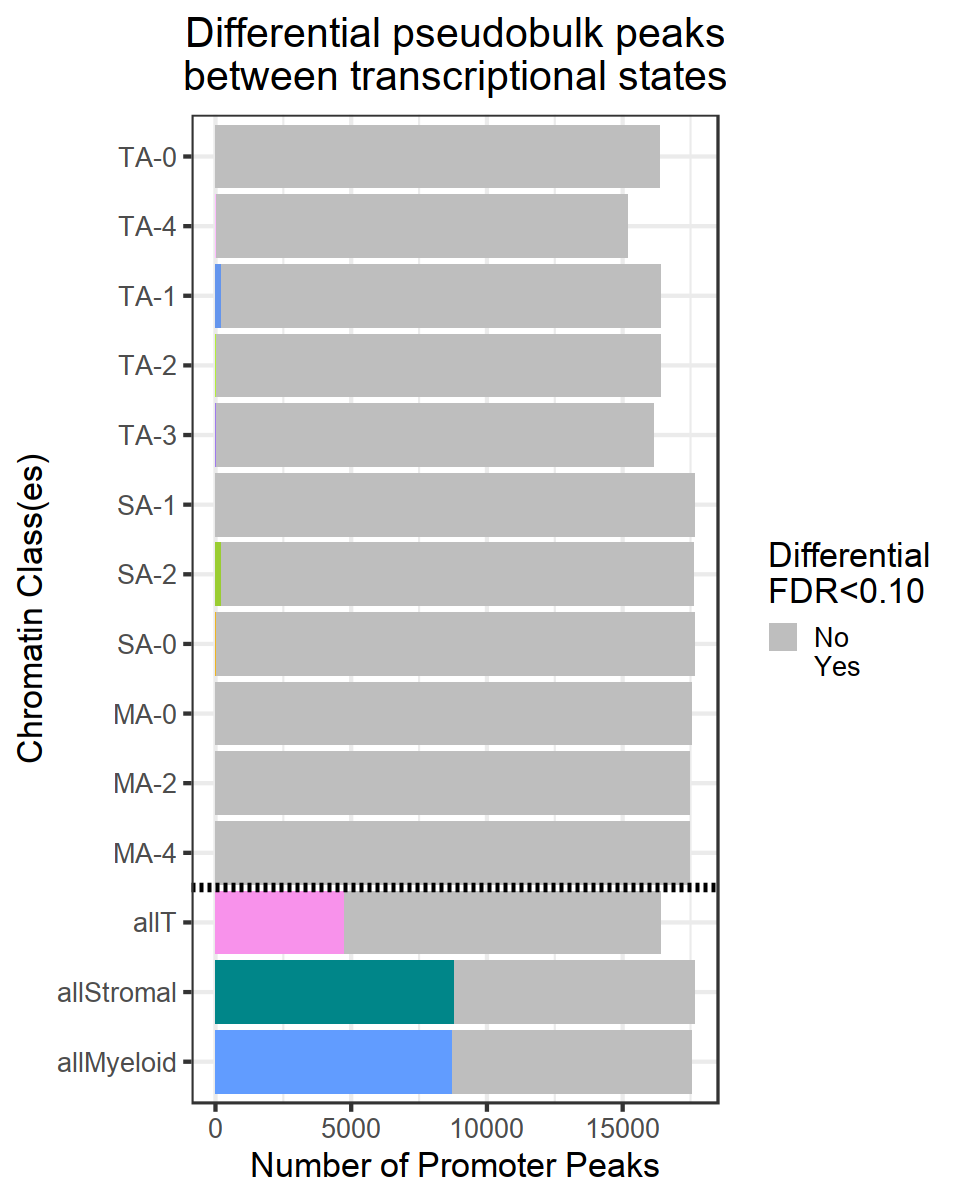

In [6]:
#Fig S12a

FDR_cutoff <- 0.10

all_pval <- rbind(Tcell_pval,stromal_pval,myeloid_pval)
all_pval$FDR <- ifelse(all_pval$padj<FDR_cutoff,TRUE,FALSE)
all_pval_counts <- as.data.frame(table(all_pval[,c('class','FDR')]),stringsAsFactors=FALSE)
all_pval_counts$color <- mapvalues(all_pval_counts$class,from=names(using_colors),to=unname(using_colors),
                                   warn_missing=FALSE)
all_pval_counts[which(all_pval_counts$FDR==FALSE),'color'] <- 'grey'

all_pval_counts$class <- factor(all_pval_counts$class,levels=rev(c('TA-0','TA-4','TA-1','TA-2','TA-3',
                                                                   'SA-1','SA-2','SA-0',
                                                                   'MA-0','MA-2','MA-4',
                                                                   'allT','allStromal','allMyeloid')))

options(repr.plot.height=10,repr.plot.width=8)
g <- ggplot(all_pval_counts,aes(y=class,x=Freq,label=Freq)) + 
        geom_bar(stat='identity',aes(fill=class)) + scale_fill_manual(values=using_colors) +
        geom_bar(stat='identity',fill='grey',aes(alpha=FDR)) + 
        scale_alpha_manual(values=c(1,0),name='Differential\nFDR<0.10',breaks=c(FALSE,TRUE),labels=c('No','Yes')) +
        theme_bw(base_size=20) + guides(fill='none') + 
        labs(y='Chromatin Class(es)',x='Number of Promoter Peaks',
             title='Differential pseudobulk peaks\nbetween transcriptional states') +
        theme(plot.title = element_text(hjust = 0.5)) + 
        geom_hline(yintercept=3.5,linetype='dashed',size=2)
print(g)

if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,'pseudobulkATAC_perClass_diffState_peakCounts',file_extension),
                            plot=g,units='in',height=10,width=8,dpi=600)

In [7]:
median(all_pval_counts[which(all_pval_counts$FDR==TRUE & 
                             !(all_pval_counts$class %in% c('allT','allStromal','allMyeloid'))),'Freq'])
median(all_pval_counts[which(all_pval_counts$FDR==TRUE & 
                             (all_pval_counts$class %in% c('allT','allStromal','allMyeloid'))),'Freq'])

[1] 23

[1] 8717

## Class example

In [8]:
Tcell_state_order <- Tcell_class_state_df$state

In [9]:
ll <- unique(Tcell_meta[,c('CITE','CITE_abbr')])
Tcell_state_name_vec <- unlist(lapply(ll$CITE,replace_space_newline_afterHalf,wiggle=2))
names(Tcell_state_name_vec) <- ll$CITE_abbr

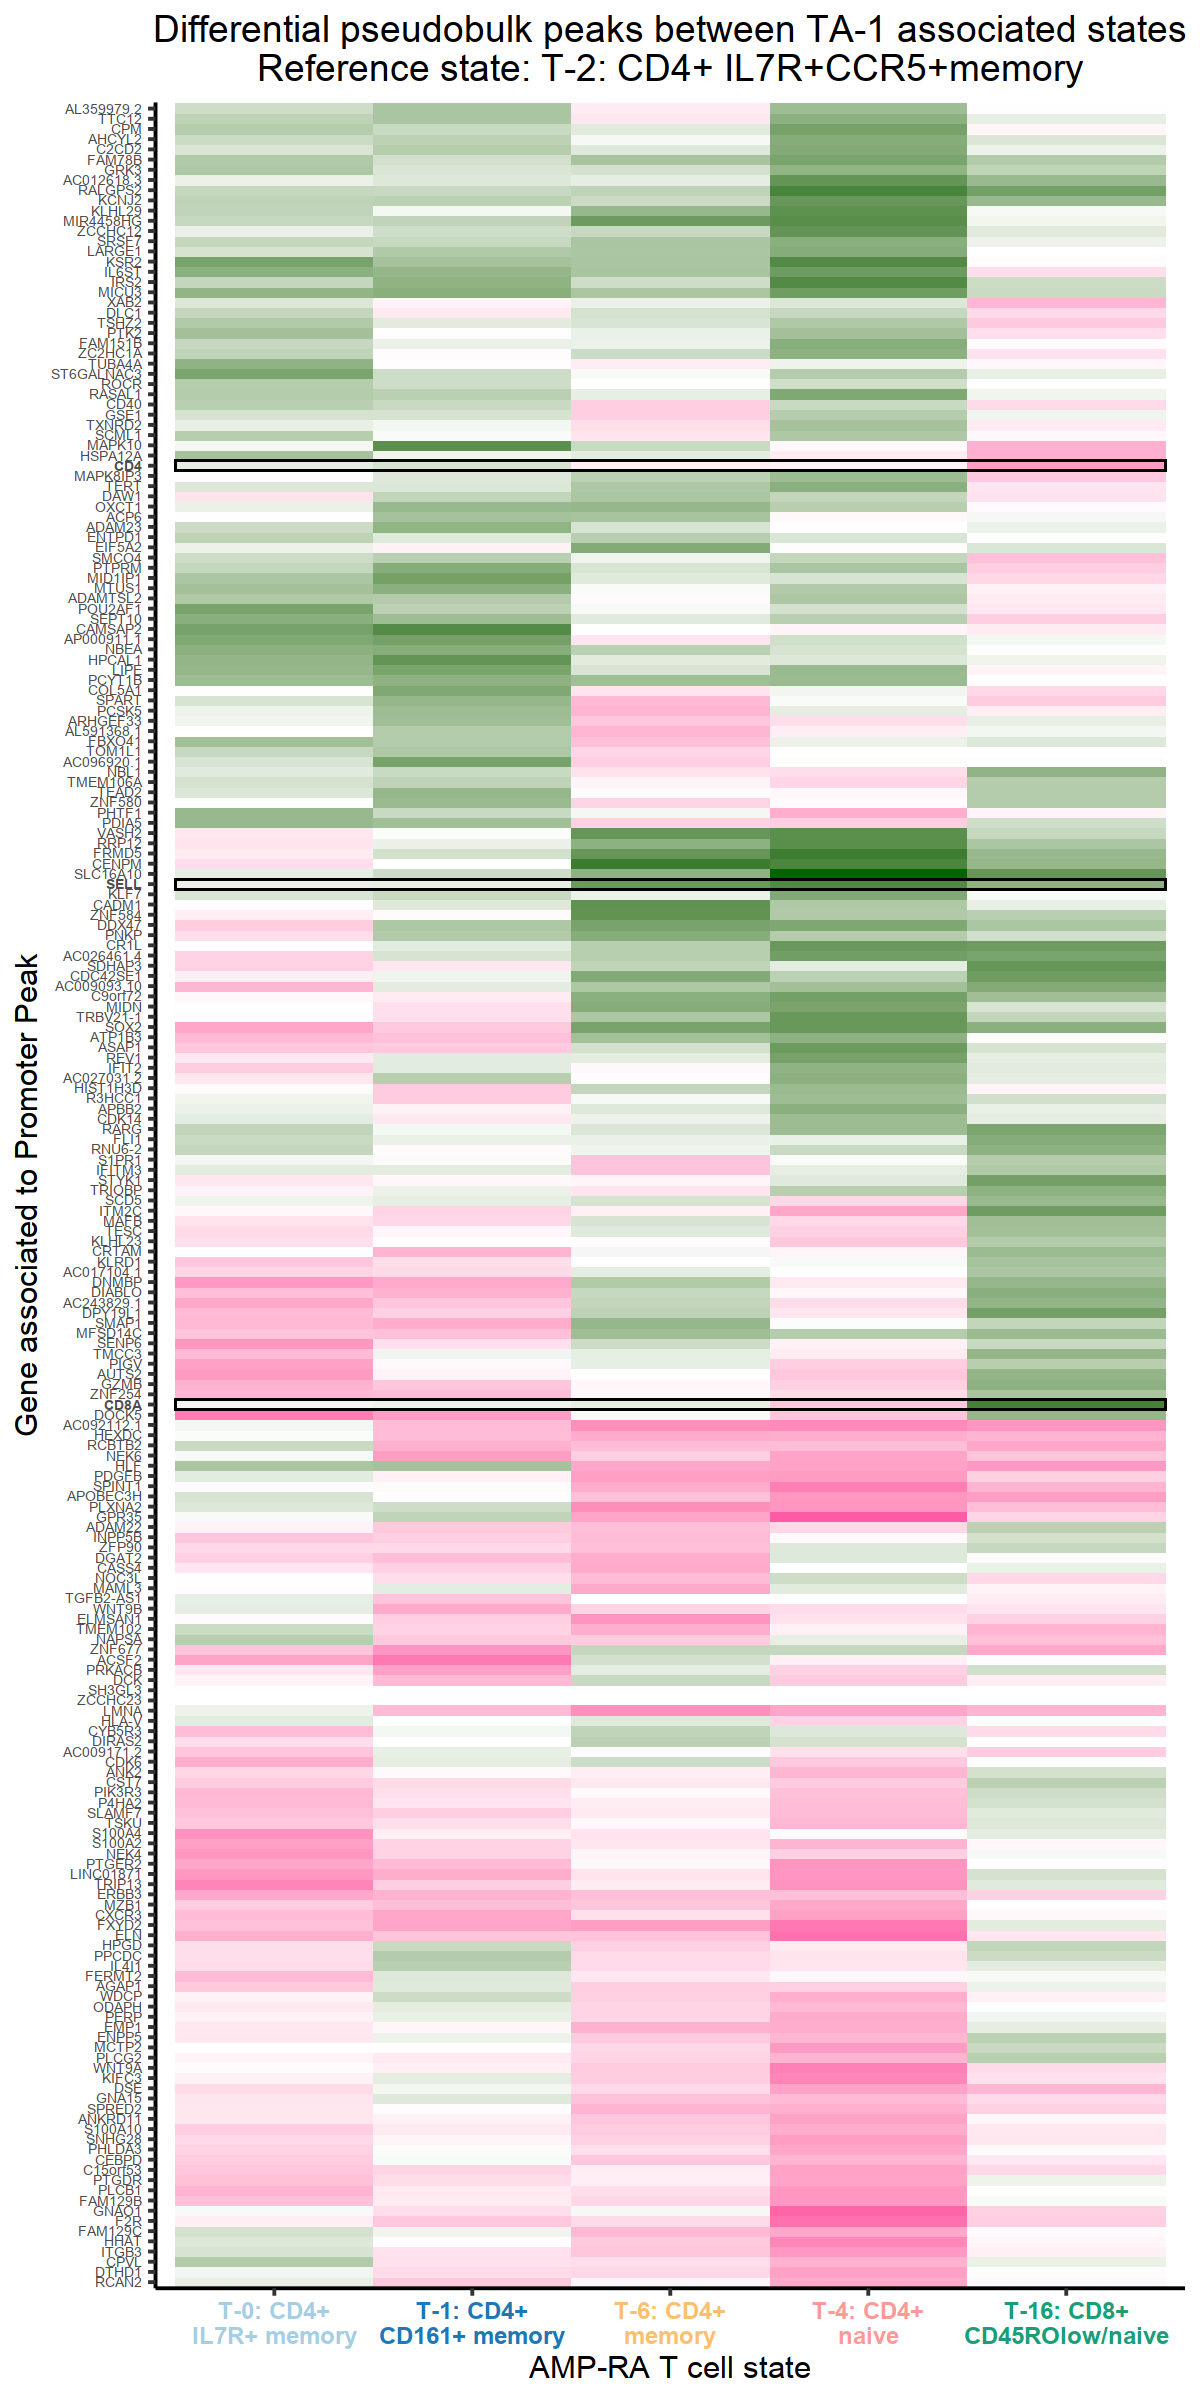

In [10]:
#Fig S12b
TA1_pval_peaks <- Tcell_pval[which(Tcell_pval$class=='TA-1' & Tcell_pval$padj<FDR_cutoff),'peak']

toPlot <- TA1_stats[which((TA1_stats$peak %in% TA1_pval_peaks) & 
                          (TA1_stats$feature %in% grep('glm_CT_.*_Z',TA1_stats$feature,value=TRUE))),]
toPlot$CITE_abbr <- unlist(lapply(sub('binMat','',str_split_fixed(toPlot$feature,'_',4)[,3]),FUN=fix_hyphen_names))
state_reorder <- Tcell_state_order[which(Tcell_state_order %in% unique(toPlot$CITE_abbr))]
peak_reorder <- reorder_peaks(toPlot,cutHeight=10.2,cutOrder=c(9,3,10,2,4,13,1,12,7,11,8,6,5))

toPlot$CITE_abbr <- factor(toPlot$CITE_abbr,levels=state_reorder)
toPlot$peak <- factor(toPlot$peak,levels=peak_reorder)
toPlot <- toPlot[order(toPlot$peak),]
toPlot$gene <- factor(toPlot$gene,levels=unique(toPlot$gene))

genes_toHighlight <- c('SELL','CD4','CD8A')
if(!all(genes_toHighlight %in% unique(toPlot$gene))) stop('Missing genes')

gene_reorder <- unique(toPlot$gene)
face_vec <- rep('plain',length(gene_reorder))
names(face_vec) <- gene_reorder
face_vec[genes_toHighlight] <- 'bold'


options(repr.plot.height=20,repr.plot.width=10)
g <- ggplot(toPlot,aes_string(y='gene',x='CITE_abbr',fill='value')) + geom_tile() +
        theme_classic(base_size=18) + scale_fill_gradient2(low='deeppink',mid='white',high='darkgreen') + 
        theme(legend.position="none", plot.title = element_text(hjust = 0.5)) + 
        labs(fill='glm Z',x='AMP-RA T cell state',y='Gene associated to Promoter Peak',
             title=paste('Differential pseudobulk peaks between TA-1 associated states\nReference state:',
                         sub('\n','',Tcell_state_name_vec['T-2']))) + 
        scale_x_discrete(labels=Tcell_state_name_vec) +
        suppressWarnings(theme(axis.text.y = element_text(size=8,face=face_vec[as.character(levels(toPlot$gene))]),
                               axis.text.x = element_text(color=CITE_colors[as.character(levels(toPlot$CITE_abbr))],
                                                          face='bold',size=14)))
for(gn in genes_toHighlight) { 
    g <- g + geom_rect(xmin=0.5, xmax=5.5, ymin=which(gene_reorder==gn)-0.5, ymax=which(gene_reorder==gn)+0.5,
                  alpha=0,color='black',size=0.5)
}
print(g)

if(!is.na(save_dir)) ggsave(file=paste(sep='',save_dir,'pseudobulkATAC_TA1_diffState_glmZ_heatmap',file_extension),
                            plot=g,units='in',height=20,width=10,dpi=600)

## Session Info

In [11]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/kew47/miniconda3/lib/R/lib/libRblas.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] repr_1.0.1         gridExtra_2.3      RColorBrewer_1.1-2 scales_1.1.1      
 [5] viridis_0.5.1      viridisLite_0.3.0  ggrepel_0.8.2      ggrastr_0.2.3     
 [9] tidyr_1.0.3        stringr_1.4.0      ggpubr_0.4.0       ggplot2_3.3.0     
[13] presto_1.0.0       Rcpp_1.0.4.6       ROCR_1.0-7         gplots_3.0.1.1    
[17] Rmisc_1.5.1        plyr_1.8.6         lattice_0.20-41    gtools_3.8.2      
[21] Matrix_1.2-18     

loaded via a namespace (and not attached):
 [1] digest_0.6.25       IRdisplay_0.7.0     R6_2.4.1           
 [4] cellranger_1.1.0    backports_1.1.6     evaluate_0.14      
